In [1]:
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import xarray as xr

import magali as mg

In [31]:
sensor_sample_distance = 5.0  # µm

coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

size = 10

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_moments = hm.magnetic_angles_to_vec(
    directions_inclination, directions_declination, amplitude
)

dipole_coordinates = (
    np.random.randint(30, 1970, size),  # µm
    np.random.randint(30, 1970, size),  # µm
    np.random.randint(-20, -1, size),  # µm
)

bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)

print(bz.min())
print(bz.max())
print(bz.mean())
print(bz.std())
print(bz.size)


-4.693868775099469e+18
1.0003971128213485e+18
-76460148158726.5
3.918804767967805e+16
1002001


In [2]:
true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

size = 10

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_moments = hm.magnetic_angles_to_vec(
    directions_inclination, directions_declination, amplitude
)

print(len(directions_inclination), len(directions_declination), len(amplitude))

10 10 10


In [3]:
dipole_coordinates = (
    np.random.randint(30, 1970, size),  # µm
    np.random.randint(30, 1970, size),  # µm
    np.random.randint(-20, -1, size),  # µm
)

print(len(dipole_coordinates[0]))

10


In [4]:
sensor_sample_distance = 5.0e-6  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

In [5]:
MICROMETER_TO_METER = 1e-6


def convet_micrometer_to_meter(coordinates):
    """
    Convert coordinates from micrometers to meters.

    Parameters:
    coordinates (tuple of float): A tuple containing coordinate values in micrometers.

    Returns:
    tuple of float: A tuple containing coordinate values converted to meters.
    """

    return tuple(c * MICROMETER_TO_METER for c in coordinates)


print(convet_micrometer_to_meter(dipole_coordinates))

print(convet_micrometer_to_meter(coordinates))

(array([0.001196, 0.001062, 0.000974, 0.001615, 0.000319, 0.000684,
       0.000765, 0.000448, 0.00037 , 0.000129]), array([1.140e-03, 1.820e-04, 1.475e-03, 4.210e-04, 4.990e-04, 6.510e-04,
       1.388e-03, 3.540e-04, 1.582e-03, 3.600e-05]), array([-7.0e-06, -1.8e-05, -1.9e-05, -1.9e-05, -1.3e-05, -6.0e-06,
       -1.1e-05, -1.2e-05, -1.5e-05, -6.0e-06]))
(array([[0.000e+00, 2.000e-06, 4.000e-06, ..., 1.996e-03, 1.998e-03,
        2.000e-03],
       [0.000e+00, 2.000e-06, 4.000e-06, ..., 1.996e-03, 1.998e-03,
        2.000e-03],
       [0.000e+00, 2.000e-06, 4.000e-06, ..., 1.996e-03, 1.998e-03,
        2.000e-03],
       ...,
       [0.000e+00, 2.000e-06, 4.000e-06, ..., 1.996e-03, 1.998e-03,
        2.000e-03],
       [0.000e+00, 2.000e-06, 4.000e-06, ..., 1.996e-03, 1.998e-03,
        2.000e-03],
       [0.000e+00, 2.000e-06, 4.000e-06, ..., 1.996e-03, 1.998e-03,
        2.000e-03]]), array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.

In [6]:
sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]
spacing = 2

In [8]:
data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)
print(data)


<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[6.80922248e+14, 7.07869259e+14, 7.36212856e+14, ...,
        1.17586891e+13, 1.16975498e+13, 1.16367266e+13],
       [6.91468455e+14, 7.19151982e+14, 7.48293402e+14, ...,
        1.18191138e+13, 1.17573952e+13, 1.16959977e+13],
       [7.01846694e+14, 7.30263184e+14, 7.60199473e+14, ...,
        1.18799771e+13, 1.18176720e+13, 1.17556932e+13],
       ...,
       [1.80113675e+13, 1.81210104e+13, 1.82313849e+13, ...,
        5.31472492e+12, 5.29636750e+12, 5.27809174e+12],
       [1.78993493e+13, 1.80077190e+13, 1.81168054e+13, ...,
        5.30117738e+12, 5.28289605e+12, 5.26469589e+12],
       [1.77881484e+13, 1.78952613e+13, 1.80030763e+13, ...,
        5.28765766e+12, 5.26945217e+12, 5.25132734e+12]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0

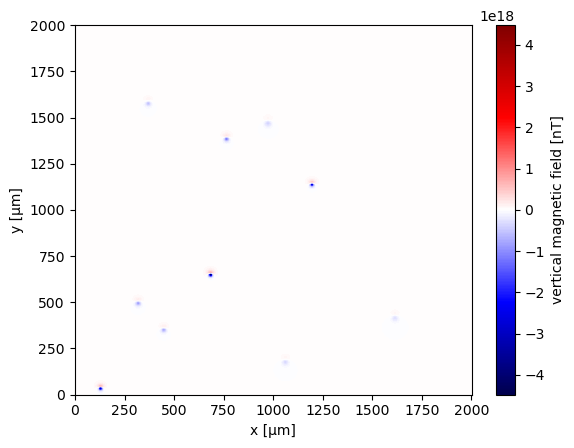

In [10]:
data.plot.pcolormesh(cmap="seismic")

# Make a model like Souza-Junior's

In [11]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

In [12]:
true_inclination = 30
true_declination = 40
true_dispersion_angle = 5


size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

### Add 3 shallow sources

In [13]:
dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

In [14]:
data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)
data

<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[ 5.54536946,  5.59539812,  5.64601906, ...,  6.77433326,
         6.74398022,  6.71343524],
       [ 5.58560735,  5.63632593,  5.68765042, ...,  6.84598397,
         6.81516496,  6.78414455],
       [ 5.62611152,  5.6775291 ,  5.72956654, ...,  6.91904222,
         6.88774514,  6.85623673],
       ...,
       [ 4.34475328,  4.3809785 ,  4.41761859, ..., 14.06062172,
        13.87040185, 13.6827709 ],
       [ 4.29637811,  4.33189037,  4.36780334, ..., 13.79300259,
        13.60833003, 13.42614364],
       [ 4.24861579,  4.28342844,  4.31862801, ..., 13.53130488,
        13.35201254, 13.175107  ]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

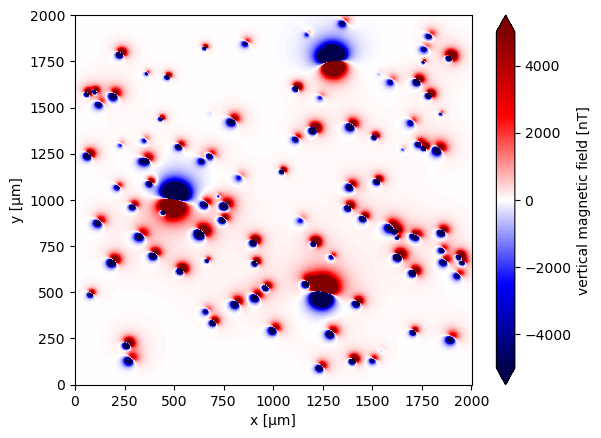

In [15]:
data.plot.pcolormesh(cmap="seismic", vmin=-5000, vmax=5000)

# Souza-Junior's method

In [16]:
sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]
spacing = 2
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

In [17]:
sources1 = 70
sources2 = 30
np.random.seed(5)

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate(
        [
            np.random.normal(0, 10, sources1),
            np.random.normal(0, 10, sources2),
            [10, -10, -5],
        ]
    ),
    declination=np.concatenate(
        [
            np.random.normal(0, 10, sources1),
            np.random.normal(180, 10, sources2),
            [10, 170, 190],
        ]
    ),
    intensity=np.concatenate(
        [
            abs(np.random.normal(0, 100, sources1 + sources2)) * 1.0e-14,
            [5e-11, 5e-11, 5e-11],
        ]
    ),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print(dipole_coordinates)

(array([ 897,  236, 1755, 1028, 1172, 1454,  103, 1062,  770, 1797,  441,
        654,  700, 1774, 1573,  234, 1965, 1167, 1491, 1134,   57, 1098,
        235, 1769, 1119, 1485, 1596, 1140, 1691,  176, 1308,  407, 1703,
       1416,   71, 1500, 1951,  240,  133, 1198, 1004,   35, 1880,  798,
        930, 1164,  706, 1927, 1745,  569,  829,  800,  354,  324, 1159,
        177,  304,  911,  275, 1189,  898,  394, 1675, 1724,  220, 1833,
       1545,  865, 1434, 1503,  213,  417,  633,  108,  831,  759,  883,
        421,  558, 1148,   44, 1016, 1853,  295, 1604, 1869,  174, 1443,
        448,  715, 1753,  438, 1451,  404, 1289,  774,   61, 1086,  362,
       1226, 1250, 1300,  500]), array([1955,  428,  205,  124,  880,  926, 1189, 1268,  558, 1118,  294,
       1528,   74,  668,  707,  124, 1513,  931,  775,  948,  210,  867,
       1776, 1754, 1913, 1083,  246,  662,  255,  506,  749, 1892,  577,
        909,  306,  207,  541,  614, 1726, 1264, 1067, 1274,  537,  781,
       1200, 1362

In [18]:
data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)
data

<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[-4.64252497e+00, -4.69289540e+00, -4.74383007e+00, ...,
        -4.41037670e-01, -4.30626488e-01, -4.20423239e-01],
       [-4.74642745e+00, -4.79755642e+00, -4.84921156e+00, ...,
        -4.46758924e-01, -4.36199699e-01, -4.25852686e-01],
       [-4.85341271e+00, -4.90528260e+00, -4.95763422e+00, ...,
        -4.52528476e-01, -4.41819506e-01, -4.31327112e-01],
       ...,
       [-1.08961827e+00, -1.09426517e+00, -1.09884474e+00, ...,
         4.38042212e-02,  1.55456020e-02, -1.17857217e-02],
       [-1.07686876e+00, -1.08135033e+00, -1.08576423e+00, ...,
         2.40134082e-02, -3.55802482e-03, -3.02258946e-02],
       [-1.06445013e+00, -1.06877274e+00, -1.07302742e+00, ...,
         4.32144761e-03, -2.25693807e-02, -4.85800641e-02]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

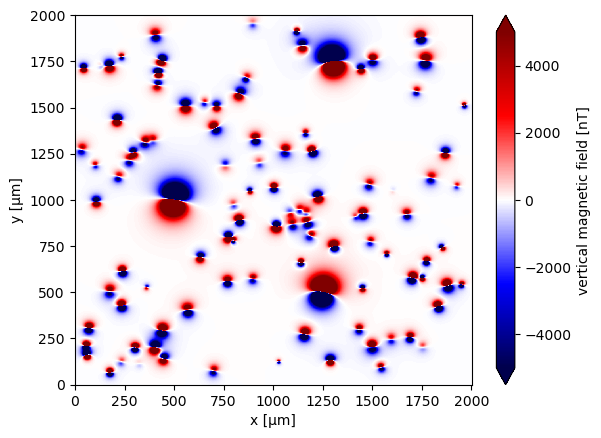

In [19]:
data.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)